Выберем парметры ижикевича, при которых возникает пачечная активность без автоколебаний

[0.002] [0.26] [-40] [2]


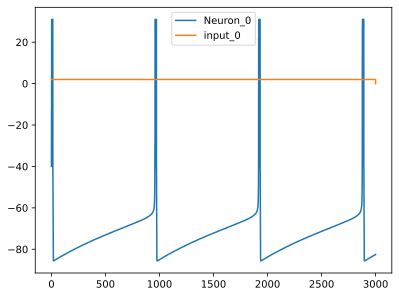

In [1]:
from Izh_net import *
from matplotlib import pyplot as plt
%config InlineBackend.figure_formats = ['svg']
def run_net(T, net, I_app):
    """
    Procedure of running network 
    args:
    T - discrete time array
    net - network object
    I_app - applied current
    I_aff - afferents activity
    retrun U, V - state of network array with shape(len(T), N), 
    N - size of
    """
    dt = T[1] - T[0]
    N = len(net)
    U = np.zeros((len(T), N))
    V = np.zeros((len(T), N))
    for i, t in enumerate(T):
        U[i] = net.U_prev
        V[i] = net.V_prev
        net.step(dt=dt, Iapp = I_app[i])
    return U, V
    
N = 1#size of network


types = ['CH']

A, B, C, D = types2params(types)
A = np.array([0.002])
B = np.array([0.26])
C = np.array([-40])
D = np.array([2])
print(A, B, C, D)
net = Izhikevich_Network(N=N, a=A, b=B, c=C, d=D)

sample_rate = 50
T_max = 3000
T = np.linspace(0, T_max , T_max*sample_rate)
I = np.zeros(N)
I[0] = 2
input = (I)*(T<3000)+ 0*np.random.normal(size=(T_max*sample_rate), scale=4)
I_aff = lambda t: 0
U, V = run_net(T, net, input) 
for i in range(N):
    plt.plot(T, V[:, i], label=f"{net.names[i]}")
    plt.plot(T, input, label=f'input_{i}')
plt.legend()
plt.show()

Во всех дальнейших опытах завиксируем 
- b = 0.26
- d = 2
- I = 2
- T = 5сек

Проведем анализ частоты пачек в зависимости от параметра a

c = -50 mV

Для локализации пачек используем следующий алгоритм:
1) рассмотрим общее чисто импульсов нейрона fire_t
2) расчитаем интенсивность спайков на всем времени симуляции: $fc = len(fire_t)/T_{max}$
3) Рассчитаем пороговое время для малого пачечного события
   $\tau_c = min(2/(fc), 100)$
4) Проходясь по всем временям спайков будем добавлять в пачку те, расстояния между которыми меньше $\tau_c$

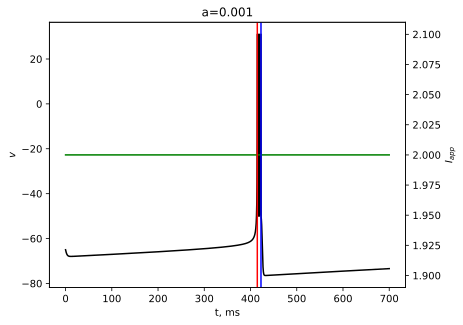

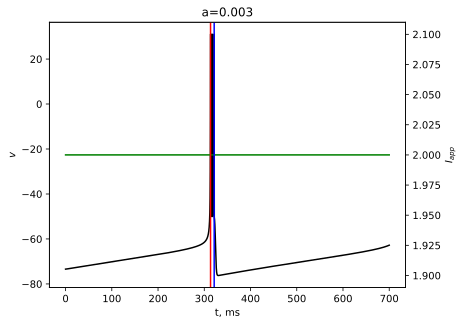

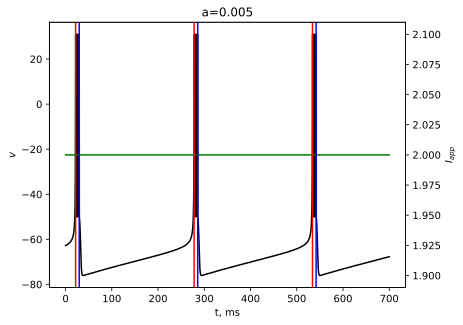

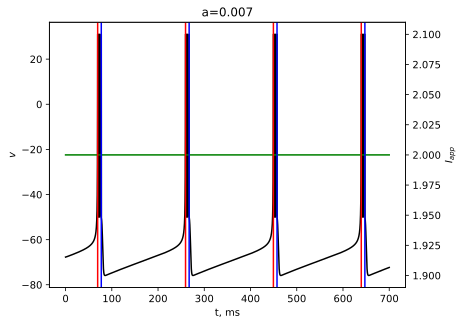

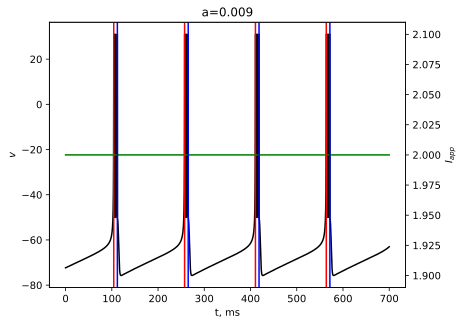

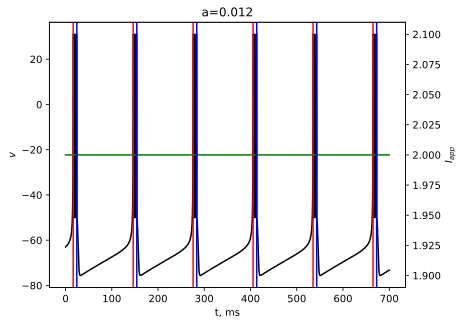

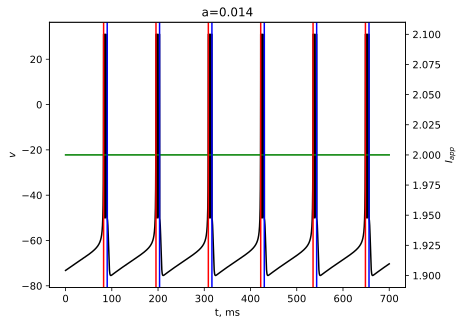

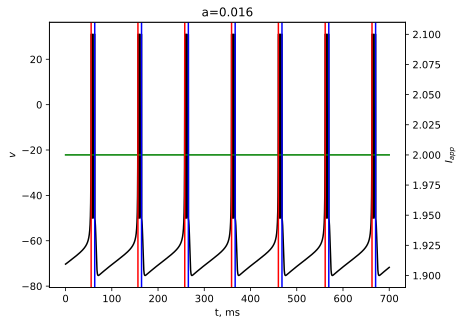

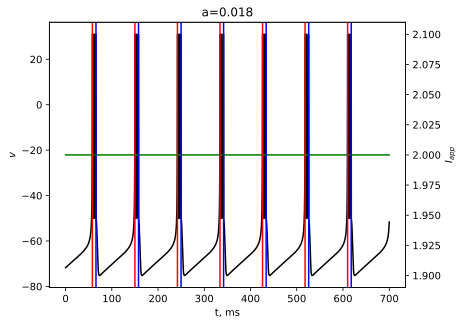

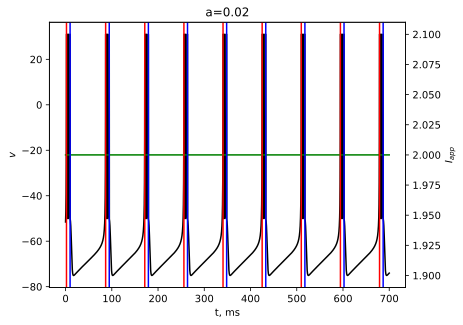

In [4]:
from net_preparation import *

net = Izhikevich_Network(N=1)
A = np.array([0.002])
B = np.array([0.26])
C = np.array([-50])
D = np.array([2])

    
    
def draw_bursts(brusts, v, T):
    for x in brusts:
        plt.axvline(x = min(x), ymin=0, ymax=1, color='red')
        plt.axvline(x = max(x), ymin=0, ymax=1, color='blue')
    return None
                   
net.set_params(a=A, b=B, c=C, d=D)
sample_rate = 50
T_max = 700
I = np.zeros(N)
I[0] = 2
T = np.linspace(0, T_max , T_max*sample_rate)
input = (I)+ 0*np.random.normal(size=(T_max*sample_rate), scale=4)
A_vals = np.linspace(0.001, 0.02, 10)

# mean and std of differences between beginings of bursts
Begin_stat = np.zeros(len(A_vals))#(mean, std)
# mean and std of differences between beginings of bursts
End_stat = np.zeros(len(A_vals))#(mean, std)

for i, a in enumerate(A_vals):
    net.set_params(a = np.array([a]))
    U, V = run_net(T, net, input) 
    firings_t, _ = create_firing_rastr(V, T, 30)
    bursts = find_bursts(firings_t, T_max)
    bursts1 = get_bursts_regions(bursts)
    begin = np.diff(bursts1[:, 0])
    end = np.diff(bursts1[:, 1])
    Begin_stat[i] = np.mean(begin)
    End_stat[i] = np.mean(end)
    fig, ax = plt.subplots()
    ax.set_title(f'a={a.round(3)}')
    ax.plot(T, V, 'k')
    ax1 = ax.twinx()
    ax1.plot(T, input, 'g')
    ax1.set_ylabel(r"$I_{app}$")
    ax.set_ylabel(r'$v$')
    ax.set_xlabel('t, ms')
    draw_bursts(bursts, V, T)
    #plt.savefig(f'A_vals/a={a}.svg')

[         nan          nan 256.13231807 190.02876273 153.20437727
 129.69370553 113.24523558 101.23789251  92.00262865  84.63116803]
[nan nan nan]


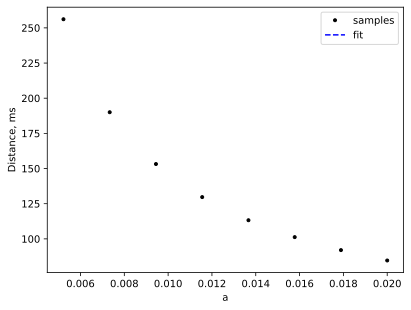

In [6]:
Distance = 0.5*(Begin_stat + End_stat)
print(Distance)
model = np.polyfit(A_vals, 1/Distance, 2)
print(model)
fit = 1/(np.polyval(model, A_vals))
plt.plot(A_vals, Distance, 'k.', label='samples')
plt.plot(A_vals, fit, label='fit', linestyle='--', color='b')
plt.ylabel('Distance, ms')
plt.xlabel('a')
plt.legend()
#plt.savefig('burst_distance_from_a.svg')
plt.show()

Получили экспоненциальное убывание расстояния между пачками при увеличении параметра а.

$$ distance \approx \frac{1}{-12.4a^2 + 0.8a + 5.5}$$




Рассчитаем зависимость длинны пачки от праметра $c$ - потенциал сброса

In [12]:
sample_rate = 50
T_max = 5000
I = np.zeros(N)
I[0] = 2
T = np.linspace(0, T_max , T_max*sample_rate)
input = (I)+ 0*np.random.normal(size=(T_max*sample_rate), scale=4)
A = np.array([0.02])
B = np.array([0.26])
C = np.array([-50])
D = np.array([2])
net.set_params(a=A, b=B, c=C, d=D)

C_vals = np.linspace(-50, -35, 20)
# mean and std of differences between beginings of bursts
duration = np.zeros((len(C_vals), 2))
for i, c in enumerate(C_vals):
    net.set_params(c = np.array([c]))
    U, V = run_net(T, net, input) 
    firings_t, _ = create_firing_rastr(V, T, 30)
    bursts = find_bursts(firings_t, T_max)
    bursts1 = get_bursts_regions(bursts)
    dur = np.mean(bursts1[:, 1] - bursts1[:, 0])
    duration[i, 0] = dur
    std = np.std(bursts1[:, 1] - bursts1[:, 0])
    duration[i, 1] = std
   # fig, ax = plt.subplots()
   # ax.set_title(f'c={c.round(3)}')
   # ax.plot(T, V, 'k-')
   # ax1 = ax.twinx()
   # ax1.plot(T, input, 'g')
   # ax1.set_ylabel(r"$I_{app}$")
   ## ax.set_ylabel(r'$v$')
  #  ax.set_xlabel('t, ms')
 #   draw_bursts(bursts, V, T)
    #plt.savefig(f'С_vals/c={c}.svg')
#plt.show()

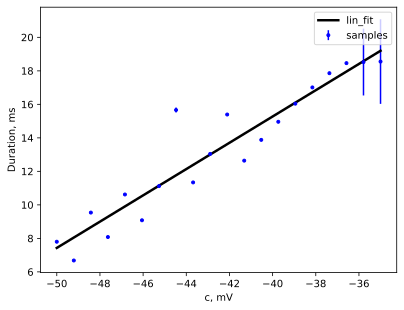

[ 0.78452108 46.65628956]


In [13]:
model = np.polyfit(C_vals, duration[:, 0], 1)
plt.errorbar(C_vals, duration[:, 0], yerr=duration[:, 1], fmt='.', c='b', label='samples')
plt.plot(C_vals, np.polyval(model, C_vals), color='black', linewidth=2.5, label='lin_fit')
plt.xlabel('c, mV')
plt.ylabel('Duration, ms')
plt.legend()
#plt.savefig('Duration1(c).svg')
plt.show()
print(model)


При изменении параметра длинна пачки изменялась по закону:
$$
Duration = 0.8\cdot c + 46.7
$$

При изменении этих параметров попбробуем пустить нормально распределенный шум на нейроны с такими параметрами


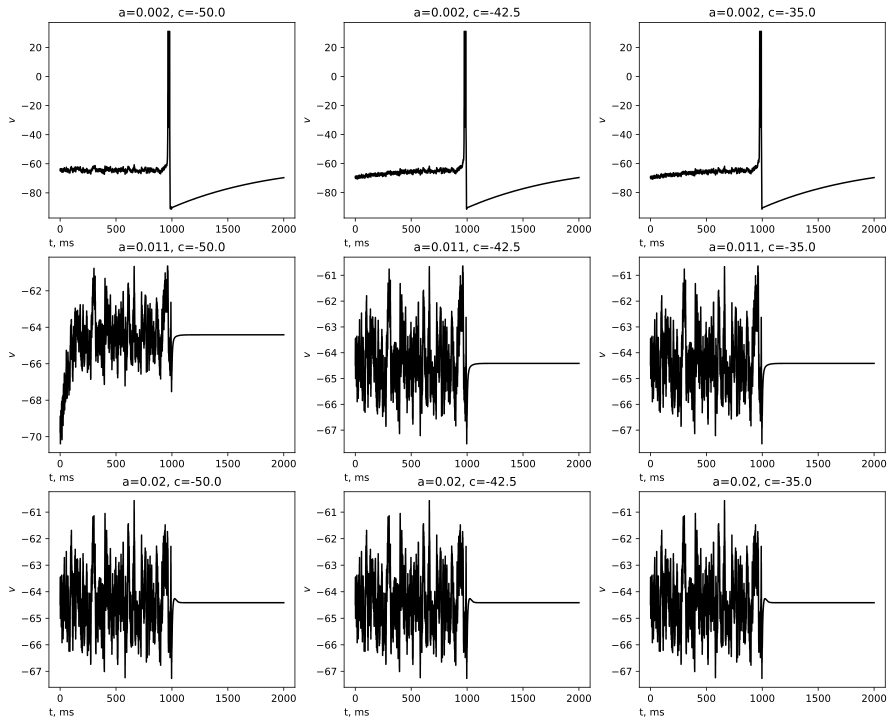

In [33]:
sample_rate = 50
T_max = 2000
I = np.zeros(N)
I[0] = 0
T = np.linspace(0, T_max , T_max*sample_rate)
input = (I)+ 1*np.random.normal(size=(T_max*sample_rate), scale=4)*(T<1000)
A_vals = np.linspace(0.002, 0.02, 3)
C_vals = np.linspace(-50, -35, 3)
net.set_params(b=np.array([0.25]))
fig, ax = plt.subplots(3, 3, figsize=(15, 12))
for i, a in enumerate(A_vals):
    for j, c in enumerate(C_vals):
        net.set_params(a = np.array([a]))
        U, V = run_net(T, net, input) 
        #firings_t, _ = create_firing_rastr(V, T, 30)
        #bursts = find_bursts(firings_t, T_max)
        #bursts1 = get_bursts_regions(bursts)
        #begin = np.diff(bursts1[:, 0])
        #end = np.diff(bursts1[:, 1])
        #Begin_stat[i] = np.mean(begin)
        #End_stat[i] = np.mean(end)
        ax[i, j].set_title(f'a={a.round(3)}, c={c.round(3)}')
        ax[i, j].plot(T, V, 'k')
        #ax1 = ax.twinx()
        #ax1.plot(T, input, 'g')
        #ax1.set_ylabel(r"$I_{app}$")
        ax[i, j].set_ylabel(r'$v$')
        ax[i, j].set_xlabel('t, ms', loc='left')
        #draw_bursts(bursts, V, T)
plt.savefig(f'AC_vals(b=0.25).jpg')
plt.show()
        